In [2]:
import scipy.signal
import torch
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import scipy
import numpy as np
# from src.utils.filters import MovingAvg
from src.utils.fourier import sphere2complex, complex2sphere

# def moving_average_freq_response(N, sample_rate, freq):
#     omega = 2 * torch.pi * freq / sample_rate
#     # SMA coefficients
#     b = np.ones(N)
#     a = np.array([N] + [0]*(N-1))

#     # Calculate the frequency response
#     w, h = scipy.signal.freqz(b, a, worN=omega)
#     # w *= sample_rate / (2 * np.pi)                      # Convert from rad/sample to Hz
#     return h

def moving_average_freq_response(N, sample_rate, freq):
    omega = 2 * torch.pi * freq / sample_rate
    coeff = torch.exp(-1j * omega * (N - 1) / 2) / N
    omega = torch.where(omega == 0, 1e-5, omega)
    Hw = coeff * torch.sin(omega * N / 2) / torch.sin(omega / 2)
    return Hw

# def moving_avg(x, N):
#     avg = torch.nn.AvgPool1d(kernel_size=N, stride=1)
#     front = x[:, 0:1, :].repeat(1, N // 2, 1)
#     end = x[:, -1:, :].repeat(1, N - 1 - N // 2, 1)
#     x = torch.cat([front, x, end], dim=1)
#     x = avg(x.permute(0, 2, 1))
#     x = x.permute(0, 2, 1)
#     return x



original signal

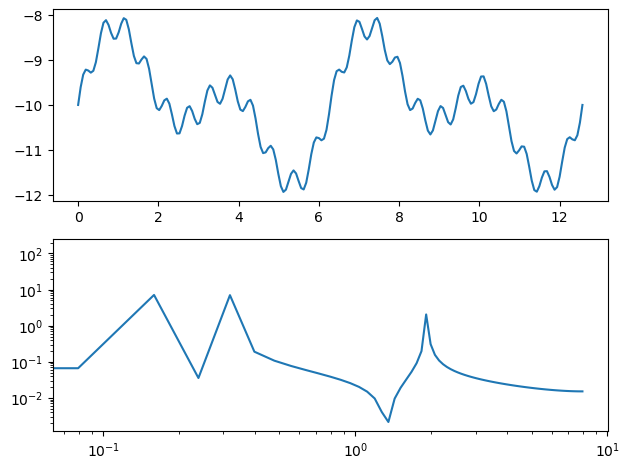

In [68]:
t = torch.linspace(0, 4*torch.pi, 200)
sample_rate = len(t)/(t.max()-t.min())
x = torch.sin(t) + torch.sin(2*t) + 0.3*torch.sin(12*t) - 10
x_freq = torch.fft.rfft(x, norm="ortho")

theta, phi = complex2sphere(x_freq.real, x_freq.imag)

freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()
phase[torch.abs(phase) < 1] = 0
fig, axs = plt.subplots(2)
axs[0].plot(t, x)
axs[1].plot(freq, x_freq.abs())
axs[1].set_yscale('log')
axs[1].set_xscale('log')
# axs[2].plot(freq, x_freq.angle())
# axs[1].plot(freq, theta)
# axs[2].plot(freq, phi)
fig.tight_layout()



manuplate on the frequency domain

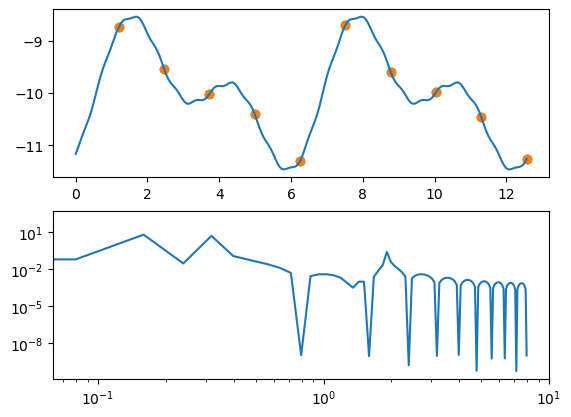

In [69]:
N = 20
h = moving_average_freq_response(N, sample_rate=sample_rate, freq=freq)
x_freq_new = x_freq * h
mag = x_freq_new.abs()
phase = x_freq_new.angle()
x_new = torch.fft.irfft(x_freq_new, norm='ortho')
x_new_avgpool = torch.nn.functional.avg_pool1d(x.reshape(1,1,-1), N,N).permute(0,2,1)
fig, axs = plt.subplots(2)
# axs[0].plot(x_new)
axs[0].plot(t, x_new)
axs[0].scatter(t[N-1::N], x_new[N-1::N])
axs[0].scatter(t[N-1::N], x_new_avgpool.flatten())
axs[1].plot(freq, mag)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
# axs[2].plot(freq, phase)

manuplate on the time domain

In [64]:
from src.utils.filters import MovingAvgTime


x_new = MovingAvgTime(x.reshape(1, -1, 1), N).flatten()
# x_new = np.convolve(np.concatenate([x[-N+1:],x]), np.ones(N)/N, mode='valid')
x_freq = torch.fft.rfft(x_new)
freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()

# mag = x_freq_new.abs()
# phase = x_freq_new.angle()
# # print(phase)
# x = torch.fft.irfft(x_freq_new)
print(x_new[N//2:-N//2])
fig, axs = plt.subplots(3)
axs[0].plot(x_new[N//2:-N//2])
# axs[1].plot(freq, mag)
# axs[2].plot(freq, phase)

NameError: name 'N' is not defined

In [12]:
class FreqLinear(torch.nn.Module):
    def __init__(self, in_channels, fft_len, kernal_size) -> None:
        super().__init__()
        self.kernel = torch.nn.Parameter(
            torch.complex(
                torch.ones(fft_len, kernal_size), torch.zeros(fft_len, kernal_size)
            ),
            requires_grad=True,
        )
        self.linear = torch.nn.Linear(kernal_size * in_channels , in_channels).to(torch.cfloat)
        self.in_channels= in_channels
        self.fft_len = fft_len
        
    def forward(self, x):
        # x = x.permute(0,2,1)
        x = torch.fft.rfft(x, norm="ortho", dim=1)
        x_channels = []
        for i in range(x.shape[-1]):
            x_channels.append(x[...,[i]] * self.kernel)
        x = torch.concat(x_channels, dim=-1)
        x = self.linear(x)
        # x = self.linear(x.flatten()).reshape(-1, self.fft_len, self.in_channels)
        x = torch.fft.irfft(x, norm="ortho", dim=1)
        return x


class TimeConv(torch.nn.Module):
    def __init__(self, in_channel) -> None:
        super().__init__()
        self.conv = torch.nn.Conv1d(
            in_channel, out_channels=in_channel, kernel_size=3, bias=False, padding=1
        )

    def forward(self, x):
        # x = x.permute(0,2,1)
        x = self.conv(x)
        return x


x = torch.sin(torch.arange(288) / 100).reshape(1, -1, 2)
m = FreqLinear(in_channels=x.shape[-1], fft_len=x.shape[1]//2+1, kernal_size=10)
for p in m.parameters():
    print(p.numel())
y = torch.ones_like(x)
loss_fn = torch.nn.MSELoss()
loss = loss_fn(y, m(x))
loss.backward()

# x = x.repeat(2,1,1)
# kernel = torch.rand(x.shape[1] // 2 + 1, 3)
# x = torch.fft.rfft(x, dim=1)
# print(x)
# print(kernel)
# print(x.shape)
# print(kernel.shape)
# x * kernel

730
40
2
torch.Size([1, 73, 2])
torch.Size([73, 10])
torch.Size([1, 73, 20])


In [6]:
import torch
x = torch.sin(torch.arange(314 * 4) / 100)
x_fft = torch.fft.rfft(x)
torch.nn.Tanh()(x_fft)
# plt.plot(x_fft.abs())
# plt.yscale("log")
# plt.xscale("log")

# x = x + torch.randn_like(x) * 0.01
# x_fft = torch.fft.rfft(x)
# plt.plot(x_fft.abs())

tensor([ 0.0052+0.0000e+00j,  0.0071+4.5265e-01j, -0.9656+1.1450e-02j,
         0.0030-9.5704e-01j,  0.0030-4.5178e-01j,  0.0031-3.1277e-01j,
         0.0031-2.4337e-01j,  0.0031-2.0068e-01j,  0.0031-1.7141e-01j,
         0.0031-1.4992e-01j,  0.0032-1.3341e-01j,  0.0032-1.2027e-01j,
         0.0032-1.0956e-01j,  0.0032-1.0063e-01j,  0.0032-9.3094e-02j,
         0.0032-8.6612e-02j,  0.0032-8.0986e-02j,  0.0032-7.6059e-02j,
         0.0032-7.1704e-02j,  0.0032-6.7825e-02j,  0.0032-6.4351e-02j,
         0.0032-6.1215e-02j,  0.0032-5.8381e-02j,  0.0032-5.5791e-02j,
         0.0032-5.3421e-02j,  0.0032-5.1247e-02j,  0.0032-4.9242e-02j,
         0.0032-4.7394e-02j,  0.0032-4.5677e-02j,  0.0032-4.4076e-02j,
         0.0032-4.2578e-02j,  0.0032-4.1187e-02j,  0.0032-3.9885e-02j,
         0.0032-3.8666e-02j,  0.0032-3.7516e-02j,  0.0032-3.6431e-02j,
         0.0032-3.5399e-02j,  0.0032-3.4434e-02j,  0.0032-3.3515e-02j,
         0.0032-3.2647e-02j,  0.0032-3.1828e-02j,  0.0032-3.1038e-02j,
      